<p> The details of the Kaggle contest in question are at https://www.kaggle.com/c/tweet-sentiment-extraction/overview. In this notebook, we attempt to pre-process input datasets to prepare them for NLP modelling. Input tweet sequences are cleaned and tokenized, and then wrapped in a BERT embedding for contextual awareness. Output text sequences are merely tokenized on an external library given the need to preserve sentence phrases. A local BERT client is used to generate the datasets. To run BERT locally, <br\><br/>
<i>
pip install bert-serving-server <br/>
pip install bert-serving-client <br/>
wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
<br/>
bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 100
</i>
<p>
    
Since we know that the selected_text is a continuous textual segment, we attempt a different design architecture, where all possible n-grams of a text are evaluated to predict the sentiment, and the most likely n-gram is the one that most clearly encapsulates the sentiment in question.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from bert_serving.client import BertClient
import sklearn.metrics
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk.probability

In [2]:
data = pd.read_csv("./data/train.csv")
testdata = pd.read_csv("./data/test.csv")
data.dropna(how="any", inplace=True)

In [3]:
def cleaner(sent):
    #Two tokens (WEBSITE, VULGAR) are created and punctuation is spaced out
    sent = " ".join(np.vectorize(lambda s:"WEBSITE" if "http" in s else s)(np.array(sent.split())))
    sent = re.sub("[!.?:;,`]", " ", sent)
    return re.sub(re.compile('(?:\*){2,}'),"VULGAR",sent).lower()
for col in ['text','selected_text']:
    data[col] = data[col].apply(lambda s: cleaner(s))
testdata['text'] = testdata['text'].apply(lambda s: cleaner(s))
data = data.loc[data.text.apply(lambda s: len(s))!=1]

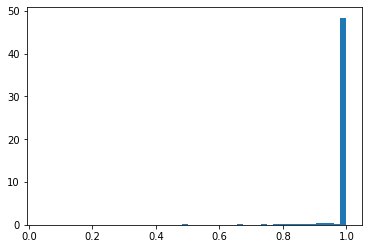

In [ ]:
#NEUTRAL SELECTION RATIO
subset = data.loc[data.sentiment=="neutral", ['selected_text', 'text']].applymap(lambda s: len(s.split()))
plt.hist(subset['selected_text']/subset['text'], bins=50, density=True);

Thus, our neutral label selection algorithm will be naive, passing the entire text as the selected_text since the approach holds for over 92% of input data. We shall now use all possible continuous n-grams from each input text and run a BERT embedding to build two separate models - positive side and negative side. For each side, the prediction quantity is the Jacardian similarity with the actual selected-text. For each tweet, the selected subtext will be the one with the highest predicted similarity.

In [ ]:
def X(text):
    ngrams, text = [], text.split()
    for i in range(len(text)):
        for j in range(i, len(text)):
            ngrams.append(" ".join(text[i:j+1]))
    return np.array(ngrams)
def Y(ngrams, subset):
    def jaccard(str1, str2):
        a, b = set(str1.lower().split()), set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    return np.vectorize(lambda s: jaccard(s, subset))(np.array(ngrams))

In [ ]:
#POSITIVE SENTIMENT
sentdata = data.loc[data.sentiment=="positive", ["text", "selected_text"]].reset_index(drop=True)
lengths = sentdata['text'].apply(lambda s: np.sum(np.arange(len(s.split())+1)))
trainX = np.zeros((lengths.sum(),), dtype=np.dtype('U150'))
trainY = np.zeros((lengths.sum(),), dtype=np.float64)
i=0
for index, content in sentdata.iterrows():
    ngrams = X(content['text'])
    trainX[i:i+len(ngrams)] = ngrams
    trainY[i:i+len(ngrams)] = Y(ngrams, content['selected_text'])
    i+=len(ngrams)
#We shall run BERT Client in groups of 20,000 to not overwhelm limited computational resources
group=20000
bc = BertClient()
for i in np.arange(0,len(trainX), group)[:2]:
    bertX = bc.encode(list(trainX[i:i+group]))
    pickle.dump(bertX, open("./data/positivetrainX/X"+str(i)+".pkl", "wb"))